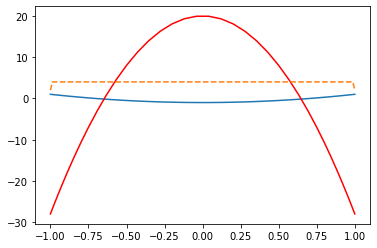

AttributeError: 'Chebyshev' object has no attribute '_stiff'

In [132]:
#https://mikaem.github.io/shenfun-demos/content/poisson.html#shen1
import numpy as np 
import matplotlib.pyplot as plt
from pypde.bases.dmsuite import *
from scipy.fftpack import dctn
from pypde.bases.chebyshev import *
from pypde.bases.inner import *
from scipy.sparse import diags
from scipy.sparse.linalg import inv
from numpy.polynomial import chebyshev as n_cheb

def f(x,m=1):
    arg = 2*np.pi/2*m
    return np.sin(arg*x)#+np.cos(arg*x)

def df(x,m=1):
    arg = 2*np.pi/2*m
    return -arg**2*np.sin(arg*x)#+np.cos(arg*x)

def pm(M):
    np.set_printoptions(formatter={'float': "{: 4.2f}\t".format})
    print(M)
    np.set_printoptions()

class ChebDirichlet(Spectralbase):
    """
    Function space for Dirichlet boundary conditions
    .. math::
        \phi_k = T_k - T_{k+2}
    
    Parameters:
        N: int
            Number of grid points
        bc: 2-tuple of floats, optional
            Boundary conditions at, respectively, x=(-1, 1).
            
    """
    def __init__(self,N,bc=(0,0)):
        Spectralbase.__init__(self,N)
        
        #self.bc = BoundaryValues(self, bc=bc) # TODO

    def eval(self,c):
        ''' 
        Evaluate f(x) from spectral coefficients c 
        '''
        y = np.zeros(self.N) 
        for i in range(self.N):
            y += c[i]*self.get_basis(i)
        return y
    
    def get_basis(self, i=0, x=None):
        if x is None: x = self.x
        if i < self.N-2:
            w = np.arccos(x)
            return np.cos(i*w) - np.cos((i+2)*w)
        elif i == self.N-2:
            return 0.5*(1-x)
        elif i == self.N-1:
            return 0.5*(1+x)
        
    def get_basis_derivative(self, i=0, k=0, x=None):
        if x is None: x = self.x
        output_array = np.zeros(x.shape)
        x = np.atleast_1d(x)
        if i < self.N-2:
            basis = np.zeros(self.N)
            basis[np.array([i, i+2])] = (1, -1)
            basis = n_cheb.Chebyshev(basis)
            if k > 0:
                basis = basis.deriv(k)
            output_array[:] = basis(x)
        elif i == self.N-2:
            output_array[:] = 0
            if k == 1:
                output_array[:] = -0.5
            elif k == 0:
                output_array[:] = 0.5*(1-x)
        elif i == self.N-1:
            output_array[:] = 0
            if k == 1:
                output_array[:] = 0.5
            elif k == 0:
                output_array[:] = 0.5*(1+x)
        return output_array
    
    def _mass(self):
        ''' 
        Eq. (2.5) of Shen - Effcient Spectral-Galerkin Method II.
        '''
        diag0 = [1.5, *[1.0]*(self.N-4), 1.5]
        diag2 = [*[-0.5]*(self.N-4) ]
        return diags([diag2, diag0, diag2], [-2, 0, 2],format="csc")
    
    def _mass_inv(self):
        return inv(self._mass())
    
    def _stiff(self):
        deriv = 2
        M = []
        N = self.N
        u = self
        v = self
        w = np.concatenate(([0.5],np.ones(N-2),[0.5] ))
        for j,vv in enumerate(v.iter_basis_deriv(deriv)):
            M.append( 
                [inner(vv,uu,w) 
                for uu in u.iter_basis()]
                )
        return np.vstack(M).transpose()
    
    def _D2(self):
        return diffmat_spectral_chebdirichlet(self.N-2,deriv=2)
    
    def iter_basis_deriv(self,deriv,sl=None):
        ''' Return iterator over all bases '''
        if sl is None: sl=self.slice()
        return (self.get_basis_derivative(i,deriv) 
            for i in range(self.N)[self.slice()])
    
    def slice(self):
        ''' 
        Chebdirichlet space defined for [0,N-3] bases + 2 BCs
        '''
        return slice(0, self.N-2)

    def forward_fft(self,f):
        '''  
        Transform to spectral space via DCT 
        '''
        c = Chebyshev.forward_fft(self,f,nomass=True)
        c = self._map(c)
        c[self.slice()] = self._mass_inv()@c[self.slice()]
        c[ [-2,-1] ] = 0 # BCs
        return c
    
    def backward_fft(self,c):
        '''  
        Transform to physical space via DCT 
        ''' 
        c = self._map(c,inv=True)
        return Chebyshev.backward_fft(self,c)
    
    @property
    def _s0(self):
        return slice(0, self.N-2)
    
    @property
    def _s1(self):
        return slice(2, self.N)
    
    def derivative(self,f,deriv,method="fft"):
        ''' 
        Calculate derivative of input array f 
        '''
        if method in ("fft", "spectral"):
            c = self.forward_fft(f)
            #dc = diff_recursion_spectral(c,deriv)
            dc = diffmat_spectral_chebdirichlet(
                self.N,deriv)@c[:-2]
            return Chebyshev.backward_fft(self,dc)
        
        elif method in ("dm", "physical"):
            return self.get_deriv_mat(deriv)@f
        else: 
            raise NotImplementedError("Not implemented method: {:s}".format(method))
    
    def _map(self,c,inv=False):
        ''' 
        Map from Galerkin to Chebshev representation.
        K. Julien: doi:10.1016/j.jcp.2008.10.043 
        '''
        _c = c; 
        if inv:
            _c[self._s1] -= _c[self._s0]
        else:
            _c[self._s0] -= _c[self._s1]
        return _c
    
    @memoized
    def get_deriv_mat(self,deriv):
        D = chebdif(self.N,deriv)[1]
        I = np.eye(self.N)
        D[:,[0,-1]] = I[:,[0,-1]] # replace row for dirichlet bcs
        return D

N = 40
CD = Chebyshev(N)
CD1 = Chebyshev(N)
x = CD.x
u = CD.get_basis(i=2)
dua = np.gradient(np.gradient(u,x),x)
#du = CD.get_basis_derivative(i=2,k=2)
plt.plot(x,u)
plt.plot(x,du,"r")
plt.plot(x,dua,"--")
plt.show()

pm(CD._stiff())

du = CD.derivative(u,deriv=2,method="fft")
plt.plot(x,u)
plt.plot(x,du,"r")
plt.plot(x,dua,"--")
plt.show()

In [133]:
def diffmat_spectral_chebdirichlet(N,deriv):
    '''Derivative matrix in spectral space of classical Chebyshev 
    polynomial on Gauss Lobattor points, see
    Jan S. Hesthaven - Appendix B p. 256  

    Input:
        N: int
            Number of grit points
        deriv: int
            Order of derivative

    Output:
        ndarray (N x N)
            Derivative matrix, must be applied in spectral
            space to chebyshev coefficients array
            '''
    M = N-2
    D = np.zeros( (N,M) )
    if deriv==1:
        for n in range(N):
            for p in range(n+1,N):
                if (p+n)%2!=0: D[n,p] = p*2
    if deriv==2:
        for m in range(N):
            for n in range(m,M):
                if (n==m):
                    D[m,n] = -2*(m+1)*(m+2)
                elif (n-m)%2==0:
                    D[m,n] = -4*(m+1)
    if deriv>2:
        raise NotImplementedError("derivatives larger 2 not implemented")
    return D
N = 7
D = diffmat_spectral_chebdirichlet(N,deriv=2)
pm(D)
D.shape

[[-4.00	  0.00	 -4.00	  0.00	 -4.00	]
 [ 0.00	 -12.00	  0.00	 -8.00	  0.00	]
 [ 0.00	  0.00	 -24.00	  0.00	 -12.00	]
 [ 0.00	  0.00	  0.00	 -40.00	  0.00	]
 [ 0.00	  0.00	  0.00	  0.00	 -60.00	]
 [ 0.00	  0.00	  0.00	  0.00	  0.00	]
 [ 0.00	  0.00	  0.00	  0.00	  0.00	]]


(7, 5)

In [125]:
import scipy
import scipy.linalg

MI = CD._mass()
#pm( MI.toarray() )

MI = CD._mass_inv()
pm( MI.toarray()  )

#P, L, U = scipy.linalg.lu(MI)

#pm(U)

[[ 0.75	  0.00	  0.25	]
 [ 0.00	  1.00	  0.00	]
 [ 0.25	  0.00	  0.75	]]


In [31]:
s = sparse.diags([0.5, *[1.0]*2, 0.5],0)
out = s@s
out.__dict__

{'_shape': (4, 4),
 'maxprint': 50,
 'indices': array([0, 1, 2, 3], dtype=int32),
 'indptr': array([0, 1, 2, 3, 4], dtype=int32),
 'data': array([0.25, 1.  , 1.  , 0.25])}

In [7]:
import numpy as np
A = [[1,2,3],[4,5,6],[7,8,9]]
A = np.array(A)
Ah = np.vstack(A)
Av = np.hstack(A)
print(Ah)
Ah.shape

[[1 2 3]
 [4 5 6]
 [7 8 9]]


(3, 3)

In [2]:
sl = slice(0,4)
for i in range(10)[sl]:
    print(i)

0
1
2
3


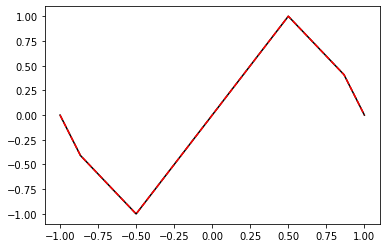

In [2]:
N = 7
CD = ChebDirichlet(N)
x = CD.x

def fun(x):
    return np.sin(2*np.pi/2*x)

c = CD.project_via_mass(fun(x))
y = CD.eval(c)
plt.plot(x,fun(x),"k")
plt.plot(x,y,"r--")
plt.show()

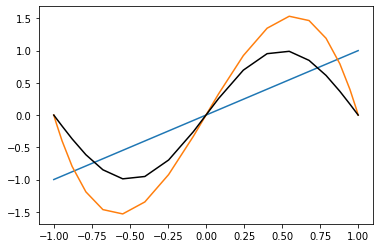

In [6]:

from shenfun import *
N = 20
D0 = FunctionSpace(N, 'C', basis='Orthogonal'   ,quad="GL")
DS = FunctionSpace(N, 'C', basis='ShenDirichlet',quad="GL")
x = D0.mesh()
plt.plot(x,D0.evaluate_basis(x,i=1))
plt.plot(x,DS.evaluate_basis(x,i=1))
plt.plot(x,fun(x),"k")
plt.show()


c = project(fun(x), D0)